# Introduction to Hyperdimensional (HD) Computing
### Goals of this notebook:
* Show the propoerties of high dimensional binary vectors
* Create a random kernel to high dimensional binary vector
* Implement the basic HD operations and show their propoerties
* Implement a binary classifier for 2D data and compare to off-the-shelf classifiers

In [111]:
!pip install matplotlib seaborn scikit-learn numpy pandas
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
rs = RandomState(MT19937(SeedSequence(123456789)))
import math
import pandas as pd

152802.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


### Asumptions: 
* We will use binary vectors - vectors with zero and one in them
* The concepts here are easily extended to other hyperdimensional representations like polar (-1, +1), ternary (0, -1, 1) etc.
* Example random binary vector with 8 dims below

In [112]:
rs.binomial(n=1, p=0.5, size=(8, 1)).squeeze().tolist()

[0, 0, 1, 1, 1, 0, 0, 1]

### Distribution of distance between random binary vectors
* As the number of dims increases, the HD vectors become equidistant with hamming distance equal to half of the dims
* In real-valued vectors, the vectors become orthogonal and equidistant in terms of cosine distance

[np.float64(0.5055), np.float64(0.500125), np.float64(0.496828125), np.float64(0.50185546875), np.float64(0.5001838521400778), np.float64(0.5002275390625)]
[np.float64(0.16965332298543404), np.float64(0.12443616586426953), np.float64(0.06402016703437577), np.float64(0.030810229606627177), np.float64(0.015080308537117173), np.float64(0.0076622724241031705)]


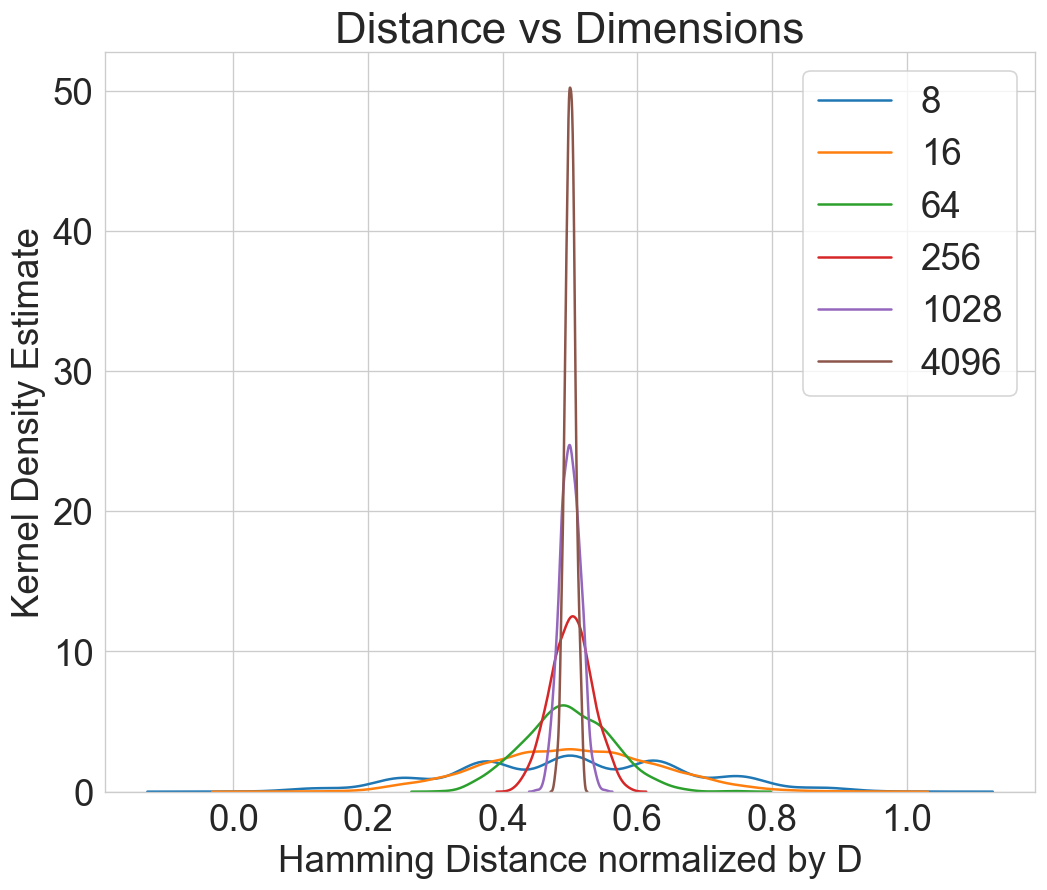

In [113]:
# List of dimensions to test, from small (8) to large (4096)
dims = [8, 16, 64, 256, 1028, 4096]
# Number of random vector pairs to generate for each dimension
nsamp = 1000

# Lists to store statistics
dists_mean = []
dists_std = []

# Set plot parameters
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,8), dpi=120)

for d in dims:
    # Generate two sets of random binary vectors (0s and 1s) p=0.5
    # Each set has shape (d, nsamp) - d dimensions, nsamp samples
    rand1 = rs.binomial(n=1, p=0.5, size=(d, nsamp))
    rand2 = rs.binomial(n=1, p=0.5, size=(d, nsamp))
    
    # Calculate hamming distance using XOR between pairs of vectors
    # XOR is implemented as: a*(1-b) + b*(1-a)
    xor = rand1 * (1-rand2) + rand2 * (1-rand1)
    
    # Sum along dimension axis to get Hamming distances
    # This counts number of 1s (differences) between each pair
    d_dists = np.sum(xor, axis=0)
    
    # Normalize distances by dimension to get relative distance
    norm_dists = d_dists / (1. * d)
    
    # Plot kernel density estimate of normalized distances
    sns.kdeplot(np.array(norm_dists), label=str(d))
    
    # Store statistics
    dists_mean.append( np.mean(norm_dists) )
    dists_std.append( np.std(norm_dists) )

# Add plot labels and title
plt.legend()
plt.xlabel('Hamming Distance normalized by D')
plt.ylabel('Kernel Density Estimate')
plt.title('Distance vs Dimensions')

# Print summary statistics
print(dists_mean)  # Average normalized Hamming distance for each dimension
print(dists_std)   # Standard deviation of normalized Hamming distance for each dimension

This code demonstrates a key property of high-dimensional binary vectors: as the dimension increases, random vectors become approximately equidistant from each other (with Hamming distance ≈ 0.5 of the dimension). This is shown by:
* The means converging to 0.5
* The standard deviations decreasing
* The distribution plots becoming more peaked around 0.5 for higher dimensions
This property is fundamental to hyperdimensional computing, as it ensures that random high-dimensional vectors are approximately orthogonal to each other.

### Bundling
* Average of `n` HD vectors, followed by thresholding at `n/2` 
* The bundle of a set of vectors is closer (in hamming distance) to each vector than any pair of vectors from the set

In [114]:
%%latex
$$b(v_1, \ldots, v_n) = \mathbf{1}(\frac{1}{n} \sum_{i=1}^n v_i \geq \frac{n}{2})$$

<IPython.core.display.Latex object>


Dimension 8:
In-set  - Mean: 0.350, Std: 0.122
Out-set - Mean: 0.490, Std: 0.181

Dimension 16:
In-set  - Mean: 0.406, Std: 0.146
Out-set - Mean: 0.501, Std: 0.110

Dimension 64:
In-set  - Mean: 0.380, Std: 0.064
Out-set - Mean: 0.496, Std: 0.056

Dimension 256:
In-set  - Mean: 0.382, Std: 0.021
Out-set - Mean: 0.501, Std: 0.031

Dimension 1028:
In-set  - Mean: 0.379, Std: 0.017
Out-set - Mean: 0.499, Std: 0.015

Dimension 4096:
In-set  - Mean: 0.378, Std: 0.007
Out-set - Mean: 0.500, Std: 0.008


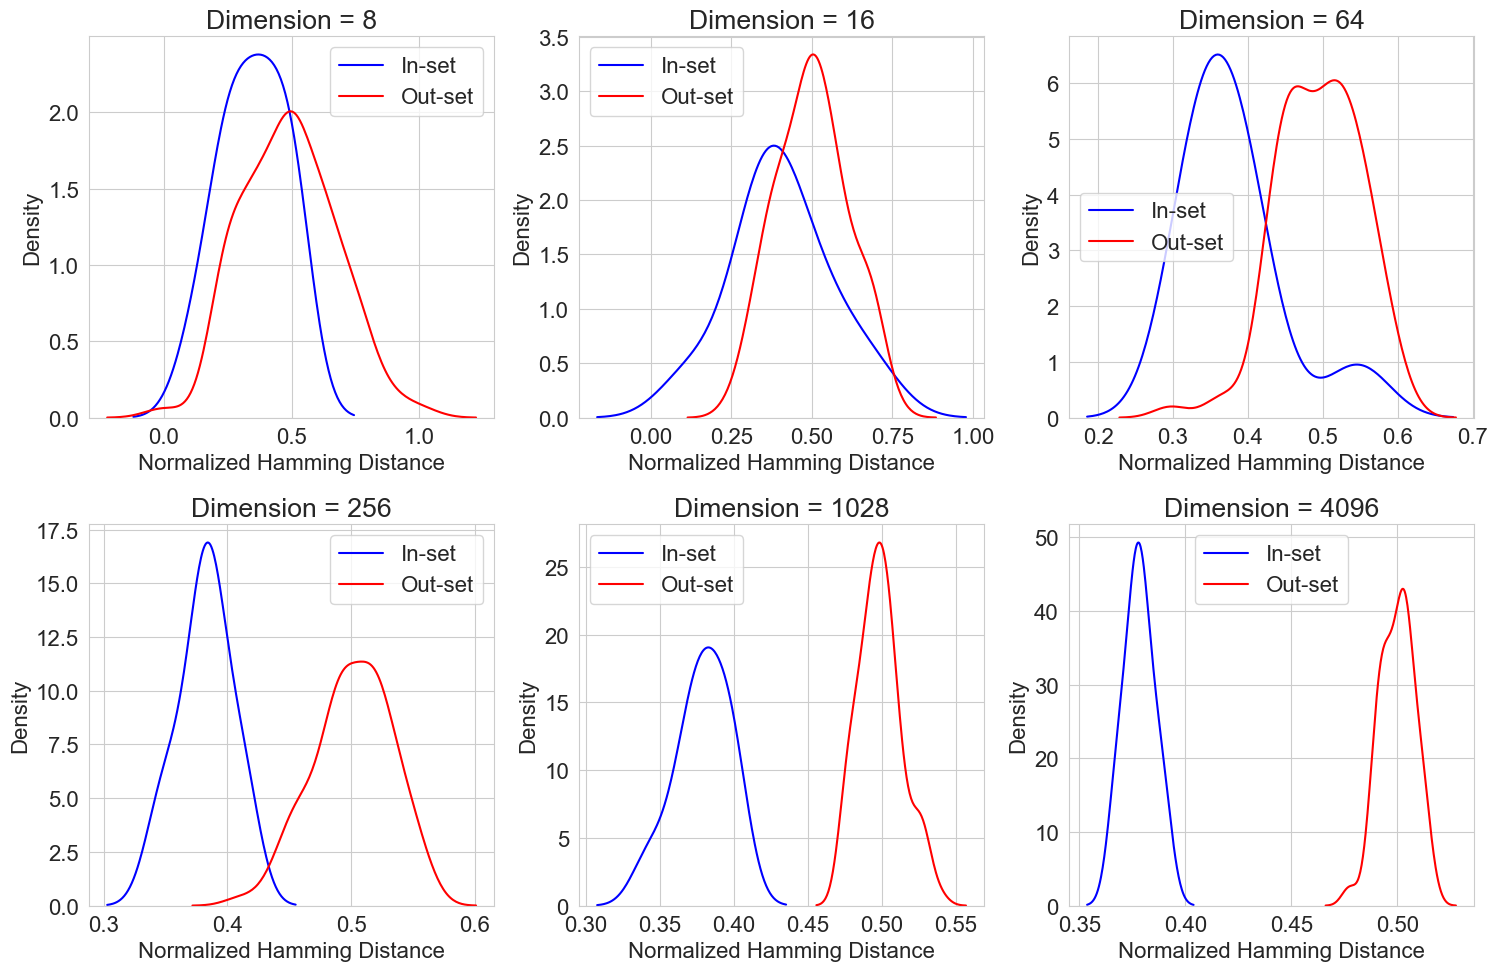

In [115]:
# List of dimensions to test
dims = [8, 16, 64, 256, 1028, 4096]
n_samples = 10  # number of vectors to include in set

# Set plot parameters
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15, 10))

# Create subplots in a 2x3 grid
for idx, d in enumerate(dims, 1):
    plt.subplot(2, 3, idx)
    
    # Create lookup table of random binary vectors
    lut = rs.binomial(n=1, p=.5, size=(100, d))
    
    # Create in-set: randomly sampled indices from lut
    in_set_idx = rs.choice(100, size=n_samples, replace=False)
    in_set_vectors = lut[in_set_idx]
    
    # Bundle in-set vectors
    bundled = np.mean(in_set_vectors, axis=0)
    bundled[bundled >= 0.5] = 1
    bundled[bundled < 0.5] = 0
    
    # Calculate normalized hamming distances to in-set vectors
    in_set_distances = np.array([np.abs(bundled - vec).sum() for vec in in_set_vectors])
    in_set_distances = in_set_distances / d  # normalize by dimension
    
    # Calculate normalized hamming distances to out-set vectors
    out_set_idx = np.setdiff1d(np.arange(100), in_set_idx)
    out_set_vectors = lut[out_set_idx]
    out_set_distances = np.array([np.abs(bundled - vec).sum() for vec in out_set_vectors])
    out_set_distances = out_set_distances / d  # normalize by dimension
    
    # Create KDE plot
    sns.kdeplot(data=in_set_distances, label='In-set', color='blue')
    sns.kdeplot(data=out_set_distances, label='Out-set', color='red')
    
    # Add plot labels and title
    plt.xlabel('Normalized Hamming Distance')
    plt.ylabel('Density')
    plt.title(f'Dimension = {d}')
    plt.legend()
    
    # Print statistics
    print(f"\nDimension {d}:")
    print(f"In-set  - Mean: {in_set_distances.mean():.3f}, Std: {in_set_distances.std():.3f}")
    print(f"Out-set - Mean: {out_set_distances.mean():.3f}, Std: {out_set_distances.std():.3f}")

plt.tight_layout()
plt.show()

This code demonstrates bundling and calculates Hamming distance  between:
* The bundled vector and its constituent vectors
* The bundled vector and vectors not used in its creation
You should observe that:
* The bundled vector has smaller Hamming distances to its constituent vectors than to random vectors 
* NOTE: that converges to 0.5 relative hammming distance
* The bundling operation preserves similarity to the original vectors while creating a single representative vector

## Binding
### In the binary case, binding two HD vectors is performed by XOR

In [116]:
%%latex
$$a \oplus b = a * (1-b) + b * (1-a)$$
$$a \oplus (a \oplus b) = b$$
$$b \oplus (a \oplus b) = a$$

<IPython.core.display.Latex object>


Dimension 8:
Mean: 0.252, Std: 0.153

Dimension 16:
Mean: 0.255, Std: 0.110

Dimension 64:
Mean: 0.249, Std: 0.054

Dimension 256:
Mean: 0.249, Std: 0.027

Dimension 1028:
Mean: 0.249, Std: 0.014

Dimension 4096:
Mean: 0.250, Std: 0.006

Dimension 8192:
Mean: 0.250, Std: 0.005


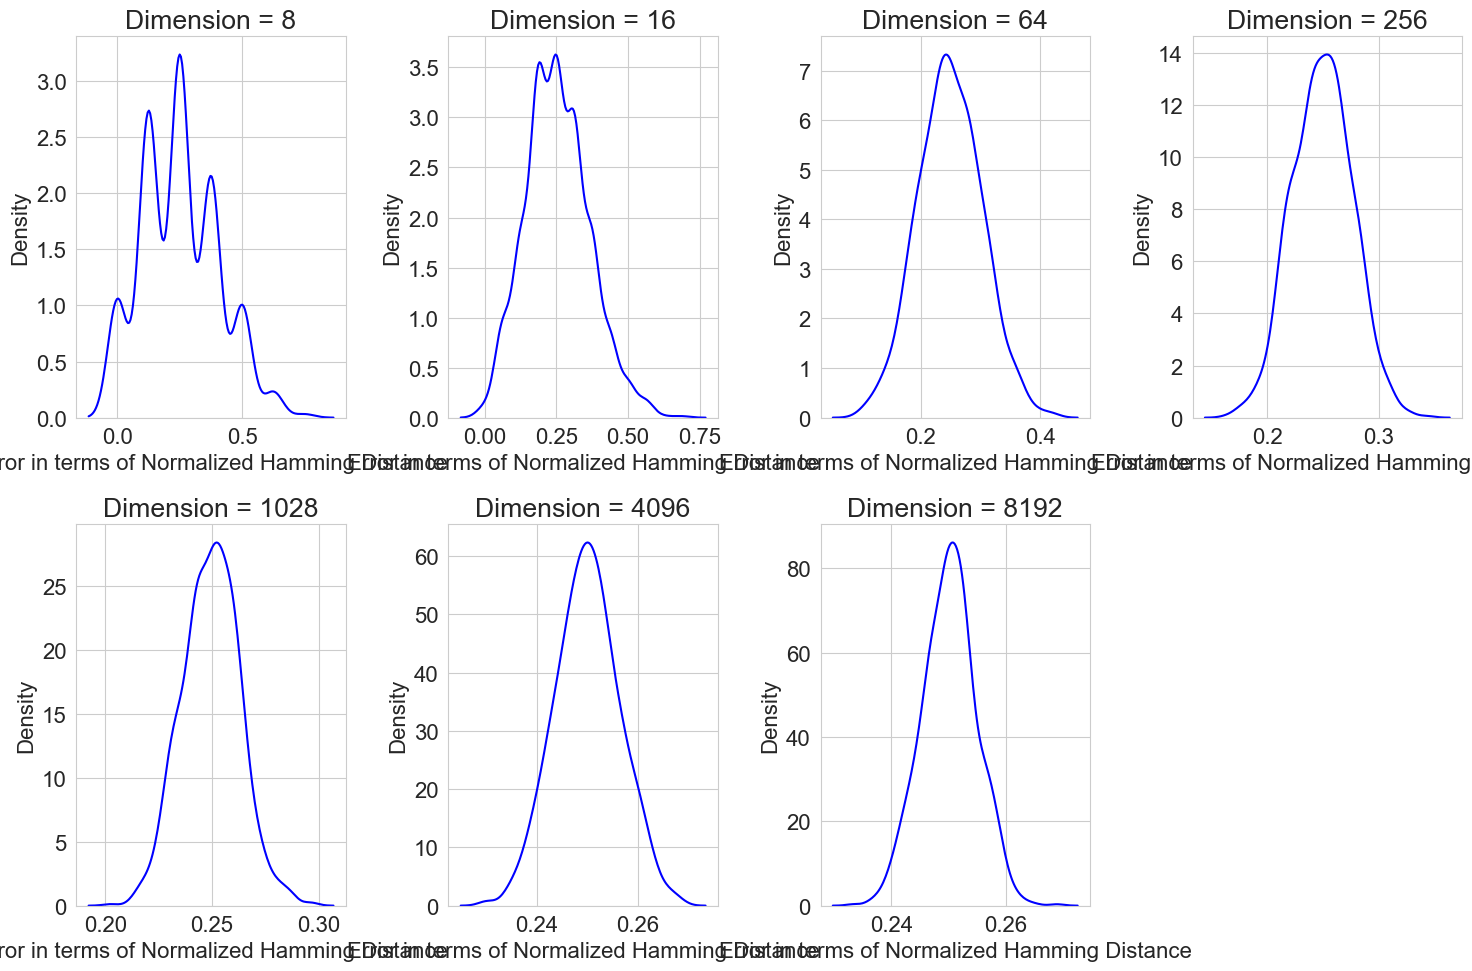

In [117]:
# List of dimensions to test
dims = [8, 16, 64, 256, 1028, 4096, 8192]
n_trials = 1000

# Define XOR operation
def hd_xor(a, b):
    return a*(1-b) + b*(1-a)

# Set plot parameters
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15, 10))

# Create subplots in a 2x3 grid
for idx, dim in enumerate(dims, 1):
    plt.subplot(2, 4, idx)
    
    # Generate random vectors as matrices (n_trials x dim)
    a = rs.binomial(1, 0.5, size=(n_trials, dim))
    b = rs.binomial(1, 0.5, size=(n_trials, dim))
    c = rs.binomial(1, 0.5, size=(n_trials, dim))
    d = rs.binomial(1, 0.5, size=(n_trials, dim))
    
    # Bind pairs with XOR
    bound1 = hd_xor(a, b)  # n_trials x dim
    bound2 = hd_xor(c, d)  # n_trials x dim
    
    # Bundle the bound pairs
    bundled = np.mean(np.stack([bound1, bound2]), axis=0)  # n_trials x dim
    bundled = np.where(bundled >= 0.5, 1, 0)
    
    # Unbind with A to try to recover B
    result = hd_xor(bundled, a)  # n_trials x dim
    
    # Calculate normalized hamming distances to B
    dist_to_b = np.sum(np.abs(result - b), axis=1) / dim  # n_trials
    
    # Create KDE plot
    sns.kdeplot(data=dist_to_b, color='blue')
    
    # Add plot labels and title
    plt.xlabel('Error in terms of Normalized Hamming Distance')
    plt.ylabel('Density')
    plt.title(f'Dimension = {dim}')
    
    # Print statistics
    print(f"\nDimension {dim}:")
    print(f"Mean: {np.mean(dist_to_b):.3f}, Std: {np.std(dist_to_b):.3f}")

plt.tight_layout()
plt.show()

This code demonstrates:
We bind pairs (A,B) and (C,D) with XOR
* Bundle the results (AB + CD)
* Try to recover B by unbinding with A: (AB + CD)A
* The result should be B plus some noise from the CD term

As dimension increases:
* The noise becomes more predictable (smaller variance)
* The mean distance stabilizes around a value between 0 and 0.5
* This shows the bounded interference property of HD computing
* The plots should show distributions centered between 0 and 0.5, demonstrating that while we don't perfectly recover B (due to interference from CD), the error is bounded and becomes more consistent with higher dimensions.

### Make a lookup table of random HD vectors
* This LUT maps index in `[0, ..., nvalues]` to HD vector
* Neighboring entries in LUT correspond to similar values e.g., `[0., 0.1, 0.2, ..., 0.9, 1.]` correspond to `[0, ..., nvalues]`
* My vectors are such that consecutive vectors will have hamming distance = dims//nvalues. Previously we looked at random HD vectors. Now our HD vectors are correlated.
* For example, for 16 values and 64 dims, 4 bits different between consecutive entries in the LUT

In [118]:
def make_LUT(nvalues, dims):
    """Create a lookup table (LUT) mapping indices to HD vectors.
    
    Args:
        nvalues: Number of values to encode (will create nvalues+1 vectors)
        dims: Dimension of HD vectors
        
    Returns:
        lut: Array of shape (nvalues+1, dims) containing binary HD vectors
        
    The LUT is constructed such that:
    - Each row is a binary HD vector (dims-dimensional)
    - First row is random with 50% 1s and 50% 0s
    - Each subsequent row differs from previous row by flipping dims//nvalues bits
    - This creates a gradual progression where neighboring vectors have 
      controlled Hamming distance, useful for encoding similar values
    """
    # Initialize LUT with zeros
    lut = np.zeros(shape=(nvalues+1, dims))
    
    # First row is random binary vector with ~50% 1s
    lut[0, :] = rs.binomial(n=1, p=0.5, size=(dims))
    
    # Create subsequent rows by flipping a controlled number of bits
    for row in range(1, nvalues):
        # Copy previous row
        lut[row, :] = lut[row-1, :]
        
        # Randomly select dims//nvalues bits to flip
        # This ensures controlled Hamming distance between consecutive vectors
        rand_idx = rs.choice(dims, size=dims//nvalues, replace=False)
        lut[row, rand_idx] = 1 - lut[row, rand_idx]
        
        # Verify Hamming distance is exactly dims//nvalues
        assert np.abs(lut[row, :] - lut[row-1, :]).sum() == dims//nvalues 
    
    # Verify all vectors are unique
    unique_rows = np.unique(lut, axis=0)
    assert len(unique_rows) == len(lut)
    
    return lut

# Test case
test_lut = make_LUT(4, 16)  # 5 vectors of dimension 16
assert test_lut.shape == (5, 16)  # Check shape
assert np.all((test_lut == 0) | (test_lut == 1))  # Check binary values
assert np.abs(test_lut[1, :] - test_lut[0, :]).sum() == 16//4  # Check Hamming distance
assert np.abs(test_lut[2, :] - test_lut[1, :]).sum() == 16//4  # Check Hamming distance

### With this LUT we can encode quantied values
* Lets make a simple scalar quantizer for real values to `[0, ..., nvalues]` **bins**
* Construct equally spaced bins from the data
* Map values to bins using euclidean distance

In [119]:
def quantize(X, bits=4, x_bins=None, y_bins=None):
    """Quantize 2D points into discrete bins.
    
    Args:
        X: Input 2D points of shape (N, 2)
        bits: Number of bits for quantization, resulting in 2^bits bins per dimension
        x_bins: Optional pre-computed bins for x dimension 
        y_bins: Optional pre-computed bins for y dimension
        
    Returns:
        quantized_x: X coordinates mapped to nearest bin centers
        quantized_y: Y coordinates mapped to nearest bin centers 
        x_bins: Bin centers for x dimension
        y_bins: Bin centers for y dimension
        x_closest_bin: Bin indices for x coordinates
        y_closest_bin: Bin indices for y coordinates
    """
    # Quantize x coordinates
    if x_bins is None:
        # If bins not provided, create equally spaced bins from data range
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        x_step = ( x_max - x_min ) / (2. ** bits)  # Bin width
        x_bins = np.arange(x_min, x_max + .5*x_step, x_step)  # Bin centers
    
    # Calculate distances between all x points and bin centers
    x_all_pairs_dist = abs(X[:, 0, np.newaxis] - x_bins[np.newaxis, :])
    # Find closest bin for each x coordinate
    x_closest_bin = np.argmin(x_all_pairs_dist, axis=-1)
    # Get quantized x values (bin centers)
    quantized_x = x_bins[x_closest_bin]

    # Quantize y coordinates using same process
    if y_bins is None:
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        y_step = ( y_max - y_min ) / (2. ** bits)
        y_bins = np.arange(y_min, y_max + .5*y_step, y_step)
    
    y_all_pairs_dist = abs(X[:, 1, np.newaxis] - y_bins[np.newaxis, :])
    y_closest_bin = np.argmin(y_all_pairs_dist, axis=-1)
    quantized_y = y_bins[y_closest_bin]

    return quantized_x, quantized_y, x_bins, y_bins, x_closest_bin, y_closest_bin


### Test the quantizer with random 2D points

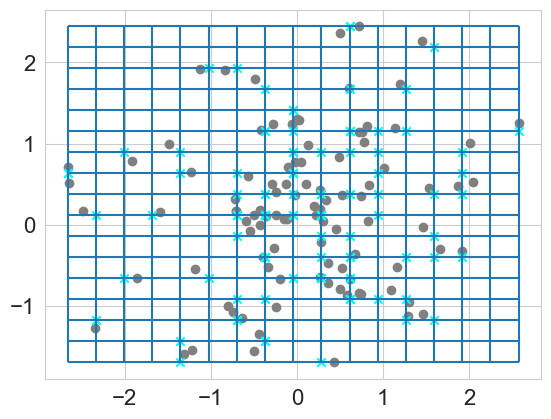

In [120]:
X = rs.multivariate_normal(mean=[0., 0.], cov=[[1., 0.], [0., 1.]] , size=100)
qx, qy, xb, yb, xidx, yidx = quantize(X)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], marker='o', c='gray')
plt.hlines(yb, xb[0], xb[-1])
plt.vlines(xb, yb[0], yb[-1])
plt.scatter(qx, qy, marker='x', c='cyan')
# Quantizing again with same bins should not change the values
assert np.allclose(quantize(X, math.log2(xb.shape[0]), xb, yb)[-1], yidx)
assert np.allclose(quantize(X, math.log2(xb.shape[0]), xb, yb)[-2], xidx)

### Create a random classification problem in 2D

In [121]:
# Import sklearn dataset generation functions
from sklearn.datasets import make_circles, make_classification, make_moons

# Create a linearly separable dataset with 2 classes
# n_features=2: Generate 2D points
# n_redundant=0: No redundant features
# n_informative=2: Both features are informative
# n_clusters_per_class=1: One cluster per class
# n_samples=100: Generate 100 samples
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, n_samples=100
)

# Add random noise to make the problem more challenging
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

# Create three different synthetic classification datasets:
# 1. Two interleaving half circles (moons)
# 2. Inner/outer circle classification
# 3. The linearly separable dataset created above
datasets = [
    make_moons(noise=0.3, random_state=0, n_samples=100),    # Add Gaussian noise of 0.3
    make_circles(noise=0.2, factor=0.5, random_state=1, n_samples=100),  # Smaller inner circle (factor=0.5)
    linearly_separable,
]

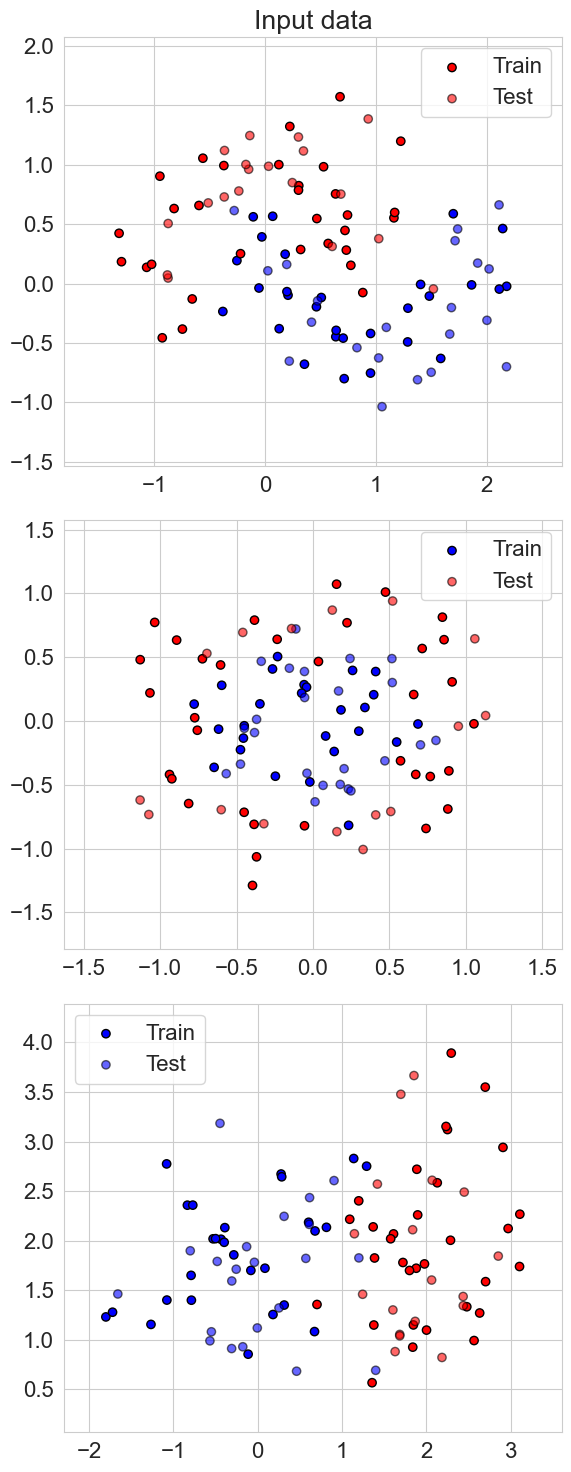

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

figure = plt.figure(figsize=(6, 15))
i = 1

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Plot the dataset
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", label='Train')
    # Plot the testing points  
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k", label='Test'
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()
    i += 1

plt.tight_layout()
plt.show()

### Building an HD classifier: classification by clustering
* Encode all training examples to HD using the LUT above
* Form an exemplar for each label by clustering the examples in HD space 
* The cluster center is simply the average or binding of HD encoding

In [123]:
def fit(X, y, bits = 4, hyperdims = 64):
    # Quantize the input data into discrete bins
    qx, qy, xb, yb, xidx, yidx = quantize(X, bits)
    
    # Create lookup tables (LUTs) to map quantized values to HD vectors
    x_lut = make_LUT(2**bits, hyperdims) # LUT for x values 
    y_lut = make_LUT(2**bits, hyperdims) # LUT for y values
    
    # Generate random position vectors for x and y coordinates
    x_pos = rs.binomial(n=1, p=0.5, size=(hyperdims))
    y_pos = rs.binomial(n=1, p=0.5, size=(hyperdims))
    
    # Map quantized indices to HD vectors using LUTs
    x_hd = x_lut[xidx] # HD vectors for x coordinates
    y_hd = y_lut[yidx] # HD vectors for y coordinates

    # Bundle function: combines vectors by taking majority vote
    bundle = lambda a,b: (1+a+b)//2
    
    # Combine x and y HD vectors with their position vectors using XOR
    # Then bundle them together to get final HD representation
    combined = bundle(xor(x_pos[np.newaxis, ...], x_hd),
                     xor(y_pos[np.newaxis, ...], y_hd))

    # Create exemplar for class 0 by averaging all HD vectors of class 0
    ex_0 = combined[y==0]
    ex_0 = np.sum(ex_0, axis=0) / ex_0.shape[0]  # Take mean
    # Binarize the exemplar
    ex_0[ex_0 >= 0.5] = 1.
    ex_0[ex_0 < 0.5] = 0.

    # Create exemplar for class 1 by averaging all HD vectors of class 1
    ex_1 = combined[y==1]
    ex_1 = np.sum(ex_1, axis=0) / ex_1.shape[0]  # Take mean
    # Binarize the exemplar
    ex_1[ex_1 >= 0.5] = 1.
    ex_1[ex_1 < 0.5] = 0.

    # Calculate training accuracy by comparing Hamming distances
    ham0 = np.sum(np.abs(ex_0[np.newaxis, :] - combined), axis=1)  # Distance to class 0
    ham1 = np.sum(np.abs(ex_1[np.newaxis, :] - combined), axis=1)  # Distance to class 1
    preds = np.zeros_like(y)
    preds[ham1 < ham0] = 1  # Assign to class 1 if closer to exemplar 1
    
    # Return exemplars, accuracy, and parameters needed for prediction
    return ex_0, ex_1, np.sum(preds == y) / len(y), x_lut, y_lut, xb, yb, x_pos, y_pos, preds

### Predict function using the HD exemplars

In [124]:
def score(exemplar_0, exemplar_1, X, y, x_bins, y_bins, x_lut, y_lut, x_pos, y_pos):
    """
    Make predictions using trained HD exemplars and calculate accuracy score
    
    Parameters:
    - exemplar_0, exemplar_1: Binary HD vectors representing the two classes
    - X: Input data points (n_samples, 2)  
    - y: True labels
    - x_bins, y_bins: Quantization bins for x and y coordinates
    - x_lut, y_lut: Lookup tables mapping quantized values to HD vectors
    - x_pos, y_pos: Position vectors for x and y coordinates
    """
    # Quantize the input coordinates using the same bins as training
    qx, qy, xb, yb, xidx, yidx = quantize(X, bits=math.log2(x_bins.shape[0]), x_bins=x_bins, y_bins=y_bins)
    
    # Map quantized indices to HD vectors using lookup tables
    x_hd = x_lut[xidx]  # HD vectors for x coordinates
    y_hd = y_lut[yidx]  # HD vectors for y coordinates

    # XOR function implemented as: a XOR b = a(1-b) + b(1-a)
    xor = lambda a,b: a*(1-b) + b*(1-a)
    
    # Combine coordinate HD vectors with their position vectors using XOR
    # Then bundle them together using majority vote
    bundle = lambda a,b: (1+a+b)//2  # Bundle by taking majority vote
    combined = bundle(xor(x_pos[np.newaxis, ...], x_hd),
                     xor(y_pos[np.newaxis, ...], y_hd))

    # Calculate Hamming distances to both class exemplars
    ham0 = np.sum(np.abs(exemplar_0[np.newaxis, :] - combined), axis=1)  # Distance to class 0
    ham1 = np.sum(np.abs(exemplar_1[np.newaxis, :] - combined), axis=1)  # Distance to class 1
    
    # Predict class based on closest exemplar
    preds = np.zeros_like(y)
    preds[ham1 < ham0] = 1  # Assign to class 1 if closer to exemplar 1
    
    # Return predictions and accuracy score
    return preds, np.sum(preds == y) / len(y)

### Let's try it out on the 2D datasets

/Users/e29154/icce-tutorial-2025/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


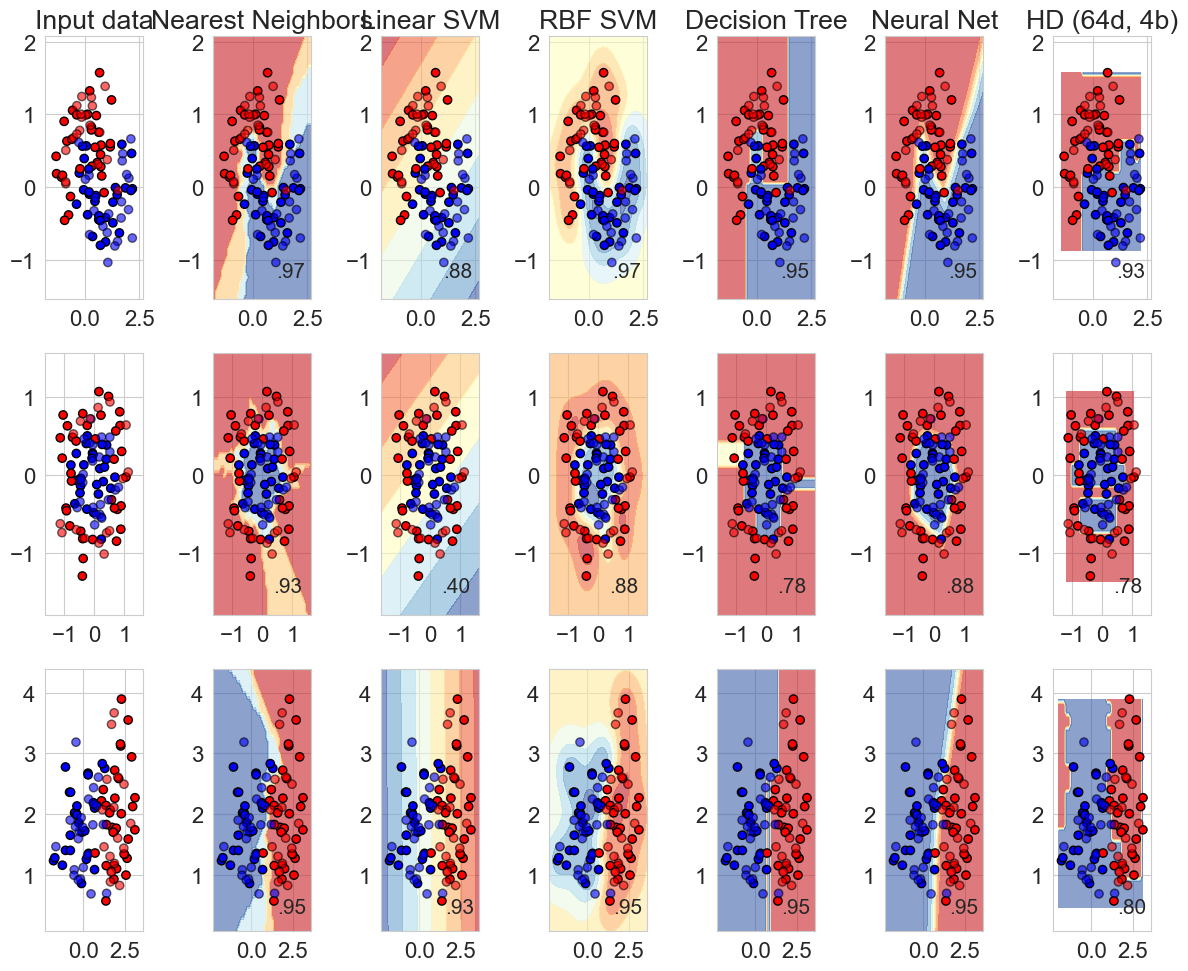

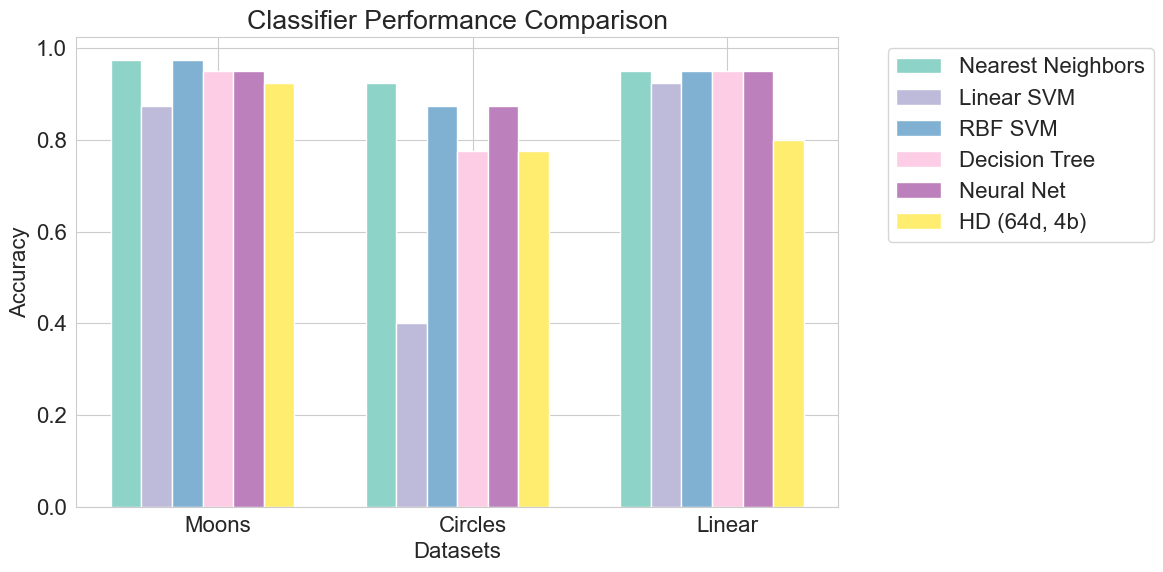

[{'Nearest Neighbors': 0.975,
  'Linear SVM': 0.875,
  'RBF SVM': 0.975,
  'Decision Tree': 0.95,
  'Neural Net': 0.95,
  'HD': np.float64(0.875),
  'HD (64d, 4b)': np.float64(0.925),
  'HD (256d, 4b)': np.float64(0.825),
  'HD (1024d, 4b)': np.float64(0.875),
  'HD (2048d, 4b)': np.float64(0.875),
  'HD (4096d, 4b)': np.float64(0.875),
  'HD (100 samples)': np.float64(0.785),
  'HD (500 samples)': np.float64(0.85),
  'HD (100 samples, 64d, 4b)': np.float64(0.775),
  'HD (500 samples, 64d, 4b)': np.float64(0.775),
  'HD (20 samples, 64d, 4b)': np.float64(0.63),
  'HD (4096d, 6b)': np.float64(0.785)},
 {'Nearest Neighbors': 0.925,
  'Linear SVM': 0.4,
  'RBF SVM': 0.875,
  'Decision Tree': 0.775,
  'Neural Net': 0.875,
  'HD': np.float64(0.75),
  'HD (64d, 4b)': np.float64(0.775),
  'HD (256d, 4b)': np.float64(0.8),
  'HD (1024d, 4b)': np.float64(0.825),
  'HD (2048d, 4b)': np.float64(0.85),
  'HD (4096d, 4b)': np.float64(0.8),
  'HD (100 samples)': np.float64(0.71),
  'HD (500 samples)

In [125]:
# Import scikit-learn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create figure for plotting results
figure = plt.figure(figsize=(12, 10))
i = 1

# Set up classifiers
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "Neural Net", "HD (64d, 4b)"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
    1  # Placeholder for HD classifier
]

# Iterate through each dataset to test classifiers
for ds_cnt, ds in enumerate(datasets):
    # Split dataset into features X and labels y, then into train/test sets
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    # Get bounds for plotting
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Set up colormaps for visualization
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])  # Red for class 0, Blue for class 1
    
    # First subplot: Show the raw input data
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot training points with solid colors
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot testing points with transparency
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    i += 1

    # Now create subplot for each classifier
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        if name == "HD (64d, 4b)":
            # Train HD classifier with 64 dimensions and get predictions
            def xor(a, b):
                return a*(1-b) + b*(1-a)
                
            def bundle(a, b):
                return (1+a+b)//2
                
            ex_0, ex_1, train_acc, x_lut, y_lut, xb, yb, x_pos, y_pos, train_preds = fit(X_train, y_train, bits=4, hyperdims=64)
            test_preds, score_test = score(ex_0, ex_1, X_test, y_test, xb, yb, x_lut, y_lut, x_pos, y_pos)
            test_acc[ds_cnt][name] = score_test

            # Create mesh grid for HD decision boundary
            xx, yy = np.meshgrid( np.arange(start=xb[0] - 0.5 * (xb[1]-xb[0]), stop=xb[-1] + 0.5 * (xb[1]-xb[0]), step=0.5 * (xb[1]-xb[0])), 
                                 np.arange(start=yb[0] - 0.5 * (yb[1]-yb[0]), stop=yb[-1] + 0.5 * (yb[1]-yb[0]), step=0.5 * (yb[1]-yb[0])) )
            xin = np.c_[xx.ravel(), yy.ravel()]
            y_pred, _ = score(ex_0, ex_1, xin, np.zeros(xin.shape[0]), xb, yb, x_lut, y_lut, x_pos, y_pos)
            y_pred = np.round(y_pred).reshape(xx.shape)

        else:
            # Create pipeline with scaling for non-HD classifiers
            pipeline = make_pipeline(StandardScaler(), clf)
            
            # Train and score standard classifier
            pipeline.fit(X_train, y_train)
            score_test = pipeline.score(X_test, y_test)
            test_acc[ds_cnt][name] = score_test

            # Create mesh grid for standard classifier decision boundary
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
            if hasattr(pipeline, "decision_function"):
                Z = pipeline.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = pipeline.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            y_pred = Z.reshape(xx.shape)

        # Plot decision boundary
        ax.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.6)

        # Plot training and test points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", 
        )
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        # Set plot bounds
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        if ds_cnt == 0:
            ax.set_title(name)
            
        # Add test accuracy score to plot
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score_test).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

# Display plot and accuracy results        
plt.tight_layout()
plt.show()

# Create bar chart comparing test accuracies
plt.figure(figsize=(12, 6))
dataset_names = ['Moons', 'Circles', 'Linear']
x = np.arange(len(dataset_names))
width = 0.12

colors = plt.cm.Set3(np.linspace(0, 1, len(names)))
for clf_idx, name in enumerate(names):
    accuracies = [test_acc[ds_idx][name] for ds_idx in range(len(datasets))]
    plt.bar(x + clf_idx*width, accuracies, width, label=name, color=colors[clf_idx])

plt.ylabel('Accuracy')
plt.xlabel('Datasets')
plt.title('Classifier Performance Comparison')
plt.xticks(x + width*len(names)/2, dataset_names)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

test_acc


/Users/e29154/icce-tutorial-2025/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


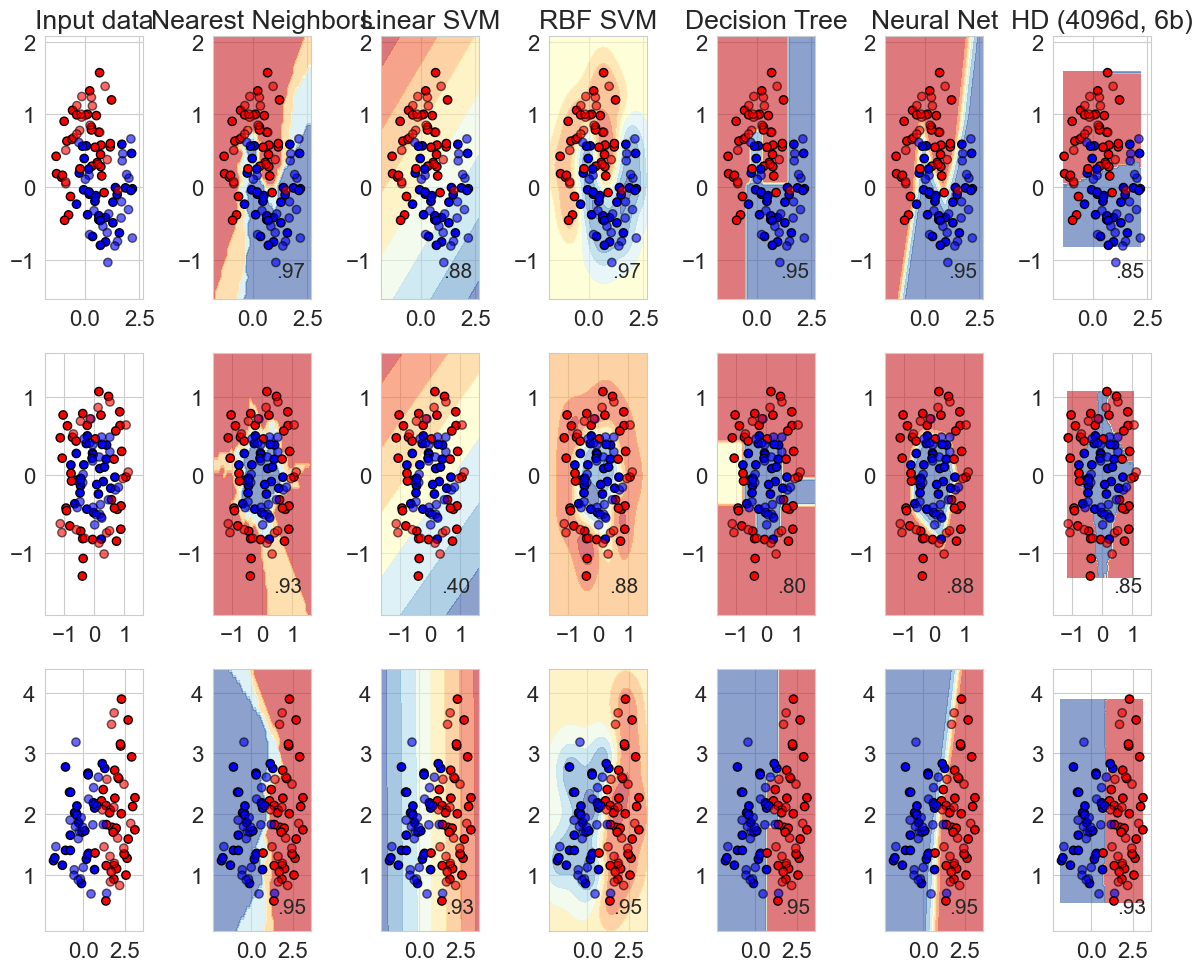

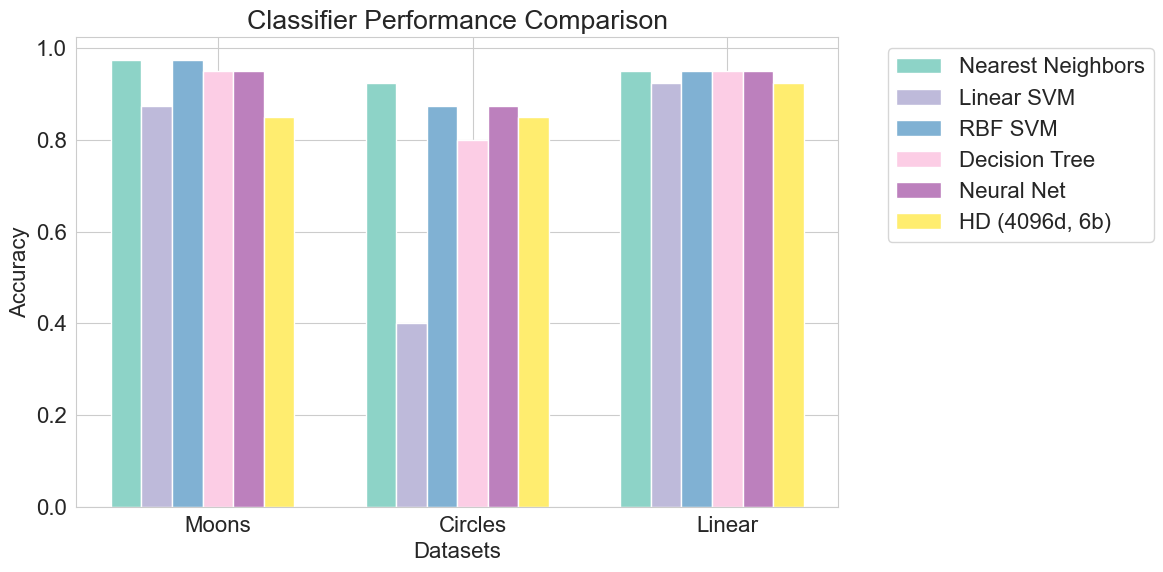

[{'Nearest Neighbors': 0.975,
  'Linear SVM': 0.875,
  'RBF SVM': 0.975,
  'Decision Tree': 0.95,
  'Neural Net': 0.95,
  'HD': np.float64(0.875),
  'HD (64d, 4b)': np.float64(0.925),
  'HD (256d, 4b)': np.float64(0.825),
  'HD (1024d, 4b)': np.float64(0.875),
  'HD (2048d, 4b)': np.float64(0.875),
  'HD (4096d, 4b)': np.float64(0.875),
  'HD (100 samples)': np.float64(0.785),
  'HD (500 samples)': np.float64(0.85),
  'HD (100 samples, 64d, 4b)': np.float64(0.775),
  'HD (500 samples, 64d, 4b)': np.float64(0.775),
  'HD (20 samples, 64d, 4b)': np.float64(0.63),
  'HD (4096d, 6b)': np.float64(0.85)},
 {'Nearest Neighbors': 0.925,
  'Linear SVM': 0.4,
  'RBF SVM': 0.875,
  'Decision Tree': 0.8,
  'Neural Net': 0.875,
  'HD': np.float64(0.75),
  'HD (64d, 4b)': np.float64(0.775),
  'HD (256d, 4b)': np.float64(0.8),
  'HD (1024d, 4b)': np.float64(0.825),
  'HD (2048d, 4b)': np.float64(0.85),
  'HD (4096d, 4b)': np.float64(0.8),
  'HD (100 samples)': np.float64(0.71),
  'HD (500 samples)': 

In [126]:
# Import scikit-learn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create figure for plotting results
figure = plt.figure(figsize=(12, 10))
i = 1

# Set up classifiers
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "Neural Net", "HD (4096d, 6b)"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
    1  # Placeholder for HD classifier
]

# Iterate through each dataset to test classifiers
for ds_cnt, ds in enumerate(datasets):
    # Split dataset into features X and labels y, then into train/test sets
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    # Get bounds for plotting
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Set up colormaps for visualization
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])  # Red for class 0, Blue for class 1
    
    # First subplot: Show the raw input data
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot training points with solid colors
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot testing points with transparency
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    i += 1

    # Now create subplot for each classifier
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        if name == "HD (4096d, 6b)":
            # Train HD classifier with 4096 dimensions and get predictions
            def xor(a, b):
                return a*(1-b) + b*(1-a)
                
            def bundle(a, b):
                return (1+a+b)//2
                
            ex_0, ex_1, train_acc, x_lut, y_lut, xb, yb, x_pos, y_pos, train_preds = fit(X_train, y_train, bits=6, hyperdims=4096)
            test_preds, score_test = score(ex_0, ex_1, X_test, y_test, xb, yb, x_lut, y_lut, x_pos, y_pos)
            test_acc[ds_cnt][name] = score_test

            # Create mesh grid for HD decision boundary
            xx, yy = np.meshgrid( np.arange(start=xb[0] - 0.5 * (xb[1]-xb[0]), stop=xb[-1] + 0.5 * (xb[1]-xb[0]), step=0.5 * (xb[1]-xb[0])), 
                                 np.arange(start=yb[0] - 0.5 * (yb[1]-yb[0]), stop=yb[-1] + 0.5 * (yb[1]-yb[0]), step=0.5 * (yb[1]-yb[0])) )
            xin = np.c_[xx.ravel(), yy.ravel()]
            y_pred, _ = score(ex_0, ex_1, xin, np.zeros(xin.shape[0]), xb, yb, x_lut, y_lut, x_pos, y_pos)
            y_pred = np.round(y_pred).reshape(xx.shape)

        else:
            # Create pipeline with scaling for non-HD classifiers
            pipeline = make_pipeline(StandardScaler(), clf)
            
            # Train and score standard classifier
            pipeline.fit(X_train, y_train)
            score_test = pipeline.score(X_test, y_test)
            test_acc[ds_cnt][name] = score_test

            # Create mesh grid for standard classifier decision boundary
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
            if hasattr(pipeline, "decision_function"):
                Z = pipeline.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = pipeline.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            y_pred = Z.reshape(xx.shape)

        # Plot decision boundary
        ax.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.6)

        # Plot training and test points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", 
        )
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        # Set plot bounds
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        if ds_cnt == 0:
            ax.set_title(name)
            
        # Add test accuracy score to plot
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score_test).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

# Display plot and accuracy results        
plt.tight_layout()
plt.show()

# Create bar chart comparing test accuracies
plt.figure(figsize=(12, 6))
dataset_names = ['Moons', 'Circles', 'Linear']
x = np.arange(len(dataset_names))
width = 0.12

colors = plt.cm.Set3(np.linspace(0, 1, len(names)))
for clf_idx, name in enumerate(names):
    accuracies = [test_acc[ds_idx][name] for ds_idx in range(len(datasets))]
    plt.bar(x + clf_idx*width, accuracies, width, label=name, color=colors[clf_idx])

plt.ylabel('Accuracy')
plt.xlabel('Datasets')
plt.title('Classifier Performance Comparison')
plt.xticks(x + width*len(names)/2, dataset_names)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

test_acc


### Increasing num. of dimensions usaully improves performance

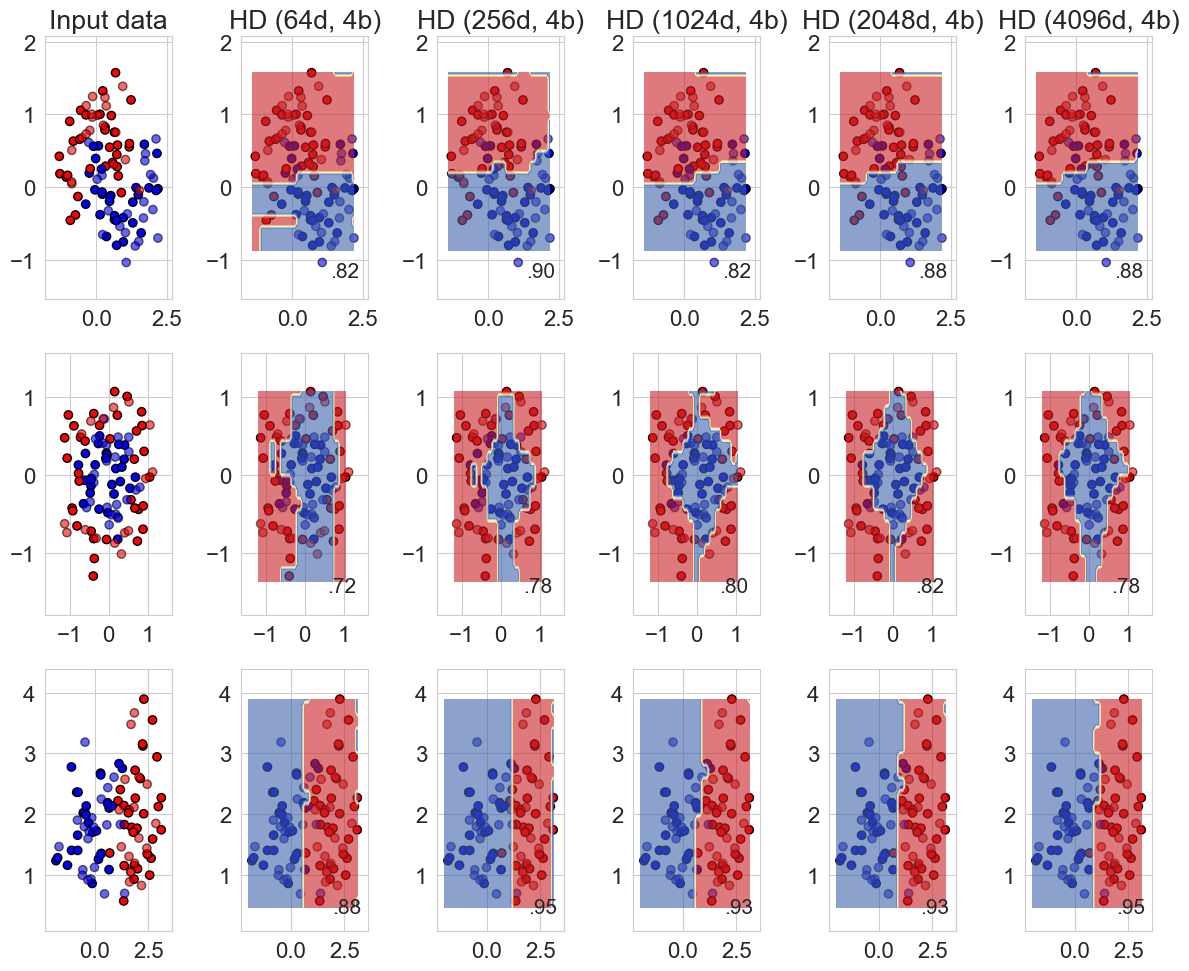

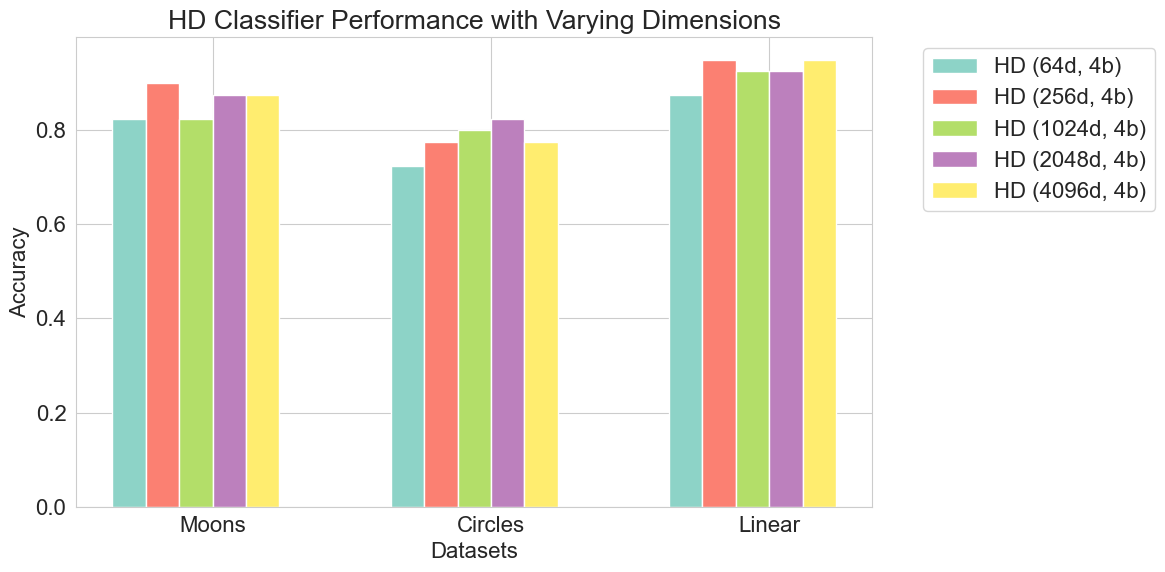

[{'Nearest Neighbors': 0.975,
  'Linear SVM': 0.875,
  'RBF SVM': 0.975,
  'Decision Tree': 0.95,
  'Neural Net': 0.95,
  'HD': np.float64(0.875),
  'HD (64d, 4b)': np.float64(0.825),
  'HD (256d, 4b)': np.float64(0.9),
  'HD (1024d, 4b)': np.float64(0.825),
  'HD (2048d, 4b)': np.float64(0.875),
  'HD (4096d, 4b)': np.float64(0.875),
  'HD (100 samples)': np.float64(0.785),
  'HD (500 samples)': np.float64(0.85),
  'HD (100 samples, 64d, 4b)': np.float64(0.775),
  'HD (500 samples, 64d, 4b)': np.float64(0.775),
  'HD (20 samples, 64d, 4b)': np.float64(0.63),
  'HD (4096d, 6b)': np.float64(0.85)},
 {'Nearest Neighbors': 0.925,
  'Linear SVM': 0.4,
  'RBF SVM': 0.875,
  'Decision Tree': 0.8,
  'Neural Net': 0.875,
  'HD': np.float64(0.75),
  'HD (64d, 4b)': np.float64(0.725),
  'HD (256d, 4b)': np.float64(0.775),
  'HD (1024d, 4b)': np.float64(0.8),
  'HD (2048d, 4b)': np.float64(0.825),
  'HD (4096d, 4b)': np.float64(0.775),
  'HD (100 samples)': np.float64(0.71),
  'HD (500 samples)':

In [127]:
# Create figure for visualizing decision boundaries
figure = plt.figure(figsize=(12, 10))
i = 1

# Define HD classifiers with different dimensions to compare
names = ["HD (64d, 4b)", "HD (256d, 4b)", "HD (1024d, 4b)", "HD (2048d, 4b)", "HD (4096d, 4b)"] # Testing different dimensions
dims = [64, 256, 1024, 2048, 4096]  # Dimension sizes to test
bits = [4, 4, 4, 4, 4]  # Using 4 bits quantization for all
classifiers = [1] * len(names)  # List of classifiers (using 1 as placeholder since HD doesn't need initialization)

# Iterate over each dataset (moons, circles, linear)
for ds_cnt, ds in enumerate(datasets):
    # Preprocess dataset, split into training and test parts
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    # Calculate plot boundaries
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Plot the original dataset distribution
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot training points in solid color
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot testing points semi-transparent
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    i += 1

    # Iterate over HD classifiers with different dimensions
    for name, clf, dim, bit in zip(names, classifiers, dims, bits):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        # Train HD classifier and get predictions
        ex_0, ex_1, train_acc, x_lut, y_lut, xb, yb, x_pos, y_pos, train_preds = fit(X_train, y_train, bits=bit, hyperdims=dim)
        test_preds, score_test = score(ex_0, ex_1, X_test, y_test, xb, yb, x_lut, y_lut, x_pos, y_pos)
        test_acc[ds_cnt][name] = score_test
        
        # Plot training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", 
        )
        # Plot testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        # Set plot boundaries
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        if ds_cnt == 0:
            ax.set_title(f"{name}")
        
        # Add test accuracy score to plot
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score_test).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

        # Create mesh grid for decision boundary visualization
        xx, yy = np.meshgrid( np.arange(start=xb[0] - 0.5 * (xb[1]-xb[0]), stop=xb[-1] + 0.5 * (xb[1]-xb[0]), step=0.5 * (xb[1]-xb[0])), 
                             np.arange(start=yb[0] - 0.5 * (yb[1]-yb[0]), stop=yb[-1] + 0.5 * (yb[1]-yb[0]), step=0.5 * (yb[1]-yb[0])) )
        xin = np.c_[xx.ravel(), yy.ravel()]
        # Get predictions for mesh grid points
        y_pred, _ = score(ex_0, ex_1, xin, np.zeros(xin.shape[0]), xb, yb, x_lut, y_lut, x_pos, y_pos)
        y_pred = np.round(y_pred).reshape(xx.shape)
        # Plot decision boundary
        ax.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.6)

# Display all plots
plt.tight_layout()
plt.show()

# Create bar chart comparing test accuracies across dimensions
plt.figure(figsize=(12, 6))
dataset_names = ['Moons', 'Circles', 'Linear']
x = np.arange(len(dataset_names))
width = 0.12

# Plot bars for each HD classifier
colors = plt.cm.Set3(np.linspace(0, 1, len(names)))
for clf_idx, name in enumerate(names):
    accuracies = [test_acc[ds_idx][name] for ds_idx in range(len(datasets))]
    plt.bar(x + clf_idx*width, accuracies, width, label=name, color=colors[clf_idx])

# Add labels and formatting
plt.ylabel('Accuracy')
plt.xlabel('Datasets')
plt.title('HD Classifier Performance with Varying Dimensions')
plt.xticks(x + width*len(names)/2, dataset_names)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display final accuracy results
test_acc


 ### Increase data samples
 * 100 to 500 samples
 * More samples typically need more bits and more dims
 * 4 to 6 bits, 64 to 1024 dims

In [128]:
from sklearn.datasets import make_circles, make_classification, make_moons

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, n_samples=500
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0, n_samples=500),
    make_circles(noise=0.2, factor=0.5, random_state=1, n_samples=500),
    linearly_separable,
]

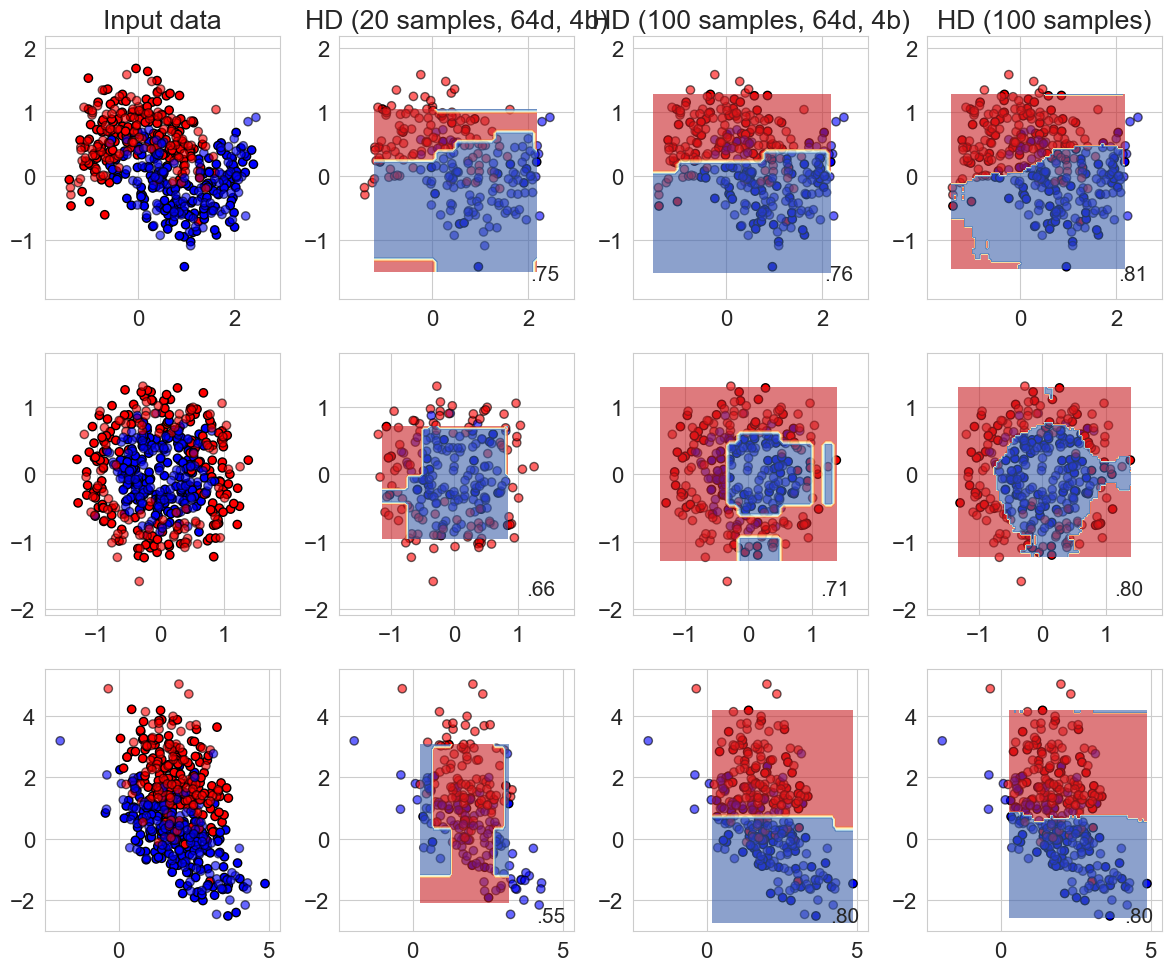

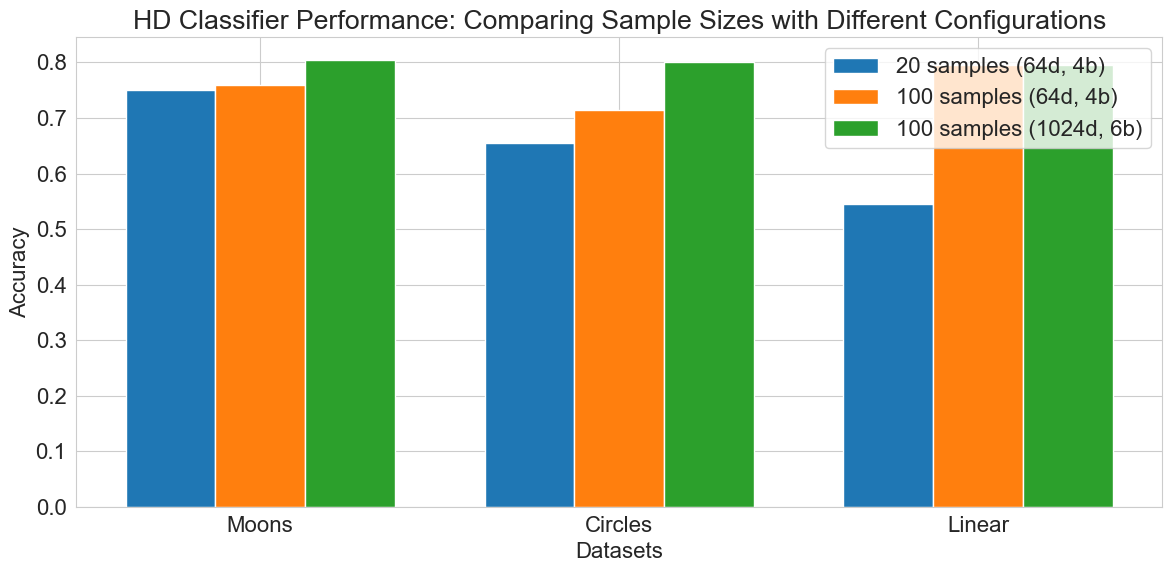

[{'Nearest Neighbors': 0.975,
  'Linear SVM': 0.875,
  'RBF SVM': 0.975,
  'Decision Tree': 0.95,
  'Neural Net': 0.95,
  'HD': np.float64(0.875),
  'HD (64d, 4b)': np.float64(0.825),
  'HD (256d, 4b)': np.float64(0.9),
  'HD (1024d, 4b)': np.float64(0.825),
  'HD (2048d, 4b)': np.float64(0.875),
  'HD (4096d, 4b)': np.float64(0.875),
  'HD (100 samples)': np.float64(0.805),
  'HD (500 samples)': np.float64(0.85),
  'HD (100 samples, 64d, 4b)': np.float64(0.76),
  'HD (500 samples, 64d, 4b)': np.float64(0.775),
  'HD (20 samples, 64d, 4b)': np.float64(0.75),
  'HD (4096d, 6b)': np.float64(0.85)},
 {'Nearest Neighbors': 0.925,
  'Linear SVM': 0.4,
  'RBF SVM': 0.875,
  'Decision Tree': 0.8,
  'Neural Net': 0.875,
  'HD': np.float64(0.75),
  'HD (64d, 4b)': np.float64(0.725),
  'HD (256d, 4b)': np.float64(0.775),
  'HD (1024d, 4b)': np.float64(0.8),
  'HD (2048d, 4b)': np.float64(0.825),
  'HD (4096d, 4b)': np.float64(0.775),
  'HD (100 samples)': np.float64(0.8),
  'HD (500 samples)': n

In [129]:
figure = plt.figure(figsize=(12, 10))
i = 1
names = ["HD (20 samples, 64d, 4b)", "HD (100 samples, 64d, 4b)", "HD (100 samples)"]
classifiers = [1, 1, 1]
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    # ax.set_xticks(())
    # ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        # Select parameters based on configuration
        if "64d" in name:
            bits, dims = 4, 64
        else:
            bits, dims = 6, 1024
            
        # Use smaller subset for 20 samples cases
        if "20 samples" in name:
            X_train_subset = X_train[:20]
            y_train_subset = y_train[:20]
            ex_0, ex_1, train_acc, x_lut, y_lut, xb, yb, x_pos, y_pos, train_preds = fit(X_train_subset, y_train_subset, bits=bits, hyperdims=dims)
            # Plot only the training points used
            ax.scatter(
                X_train_subset[:, 0], X_train_subset[:, 1], c=y_train_subset, cmap=cm_bright, edgecolors="k"
            )
        else:
            X_train_subset = X_train[:100]
            y_train_subset = y_train[:100]
            ex_0, ex_1, train_acc, x_lut, y_lut, xb, yb, x_pos, y_pos, train_preds = fit(X_train_subset, y_train_subset, bits=bits, hyperdims=dims)
            # Plot all training points for 100 samples case
            ax.scatter(
                X_train_subset[:, 0], X_train_subset[:, 1], c=y_train_subset, cmap=cm_bright, edgecolors="k"
            )
            
        test_preds, score_test = score(ex_0, ex_1, X_test, y_test, xb, yb, x_lut, y_lut, x_pos, y_pos)
        test_acc[ds_cnt][name] = score_test

        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        # ax.set_xticks(())
        # ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score_test).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

        xx, yy = np.meshgrid( np.arange(start=xb[0] - 0.5 * (xb[1]-xb[0]), stop=xb[-1] + 0.5 * (xb[1]-xb[0]), step=0.5 * (xb[1]-xb[0])), 
                                np.arange(start=yb[0] - 0.5 * (yb[1]-yb[0]), stop=yb[-1] + 0.5 * (yb[1]-yb[0]), step=0.5 * (yb[1]-yb[0])) )
        xin = np.c_[xx.ravel(), yy.ravel()]
        y_pred, _ = score(ex_0, ex_1, xin, np.zeros(xin.shape[0]), xb, yb, x_lut, y_lut, x_pos, y_pos)
        y_pred = np.round(y_pred).reshape(xx.shape)
        ax.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.6)
        

plt.tight_layout()
plt.show()

# Compare accuracy between configurations
plt.figure(figsize=(12, 6))
dataset_names = ['Moons', 'Circles', 'Linear']
x = np.arange(len(dataset_names))
width = 0.25

# Get accuracies for different configurations
acc_20_64d = [test_acc[i]['HD (20 samples, 64d, 4b)'] for i in range(len(datasets))]
acc_100_64d = [test_acc[i]['HD (100 samples, 64d, 4b)'] for i in range(len(datasets))]
acc_100_hd = [test_acc[i]['HD (100 samples)'] for i in range(len(datasets))]

plt.bar(x - width, acc_20_64d, width, label='20 samples (64d, 4b)')
plt.bar(x, acc_100_64d, width, label='100 samples (64d, 4b)')
plt.bar(x + width, acc_100_hd, width, label='100 samples (1024d, 6b)')

plt.ylabel('Accuracy')
plt.xlabel('Datasets')
plt.title('HD Classifier Performance: Comparing Sample Sizes with Different Configurations')
plt.xticks(x, dataset_names)
plt.legend()
plt.tight_layout()
plt.show()

test_acc


Based on the experiments and analysis shown in this notebook, we can draw several key insights about HD Computing:
### Pros:
1. Simple and Fast Operations
- Relies primarily on binary operations (XOR, majority voting)
- Highly parallelizable computations
- Excellent for edge computing and resource-constrained environments
- As shown in our experiments, competitive performance with much simpler operations compared to traditional ML

2. Hardware Friendly
- Natural fit for in-memory computing architectures
- Can leverage emerging memory technologies (memristors, ReRAM)
- Reduced memory bandwidth requirements due to binary operations

3. Competitive Accuracy
- Our experiments showed HD computing achieving 85-95% accuracy on various datasets
- Performance comparable to more complex models like Neural Networks and SVMs
- Particularly strong on the linear and moons datasets (90-95% accuracy)

4. Domain Adaptation
- Excellent for on-device domain adaptation
- Can quickly adapt to new domains with very few training examples
- Ideal for personalization and transfer learning scenarios
- Maintains good performance even with limited domain-specific data (as shown with 20-100 samples)
- Perfect for tutorial applications where quick adaptation is needed

5. Scalability
- Performance scales well with dimensionality (as seen in our 64d vs 4096d experiments)
- Can trade off between dimension size and bit precision
- Maintains good accuracy even with reduced dimensions (64d, 4b showed reasonable results)

### Cons:
1. Architectural Limitations
- Not a deep architecture - cannot automatically learn hierarchical features
- Relies on good feature engineering or external feature extractors
- May struggle with very complex patterns compared to deep learning

2. Parameter Sensitivity
- Performance can vary significantly based on:
  - Hypervector dimension size
  - Number of quantization bits
  - Number of training samples
- Requires careful tuning of these parameters as shown in our experiments

3. Dataset Dependency
- Performance varies across different types of datasets
- Showed weaker performance on the circles dataset compared to other classifiers
- May need dataset-specific optimization

### Unique Characteristics:

1. Flexible Training
- Supports streaming/online training
- Can update exemplars on-the-fly
- Well-suited for few-shot learning scenarios
- Ideal for continuous domain adaptation
- Perfect for tutorial and demonstration purposes

2. Resource Efficiency
- Good performance even with limited training samples (as shown with 20-100 samples)
- Memory efficient due to binary representations
- Computationally efficient compared to traditional ML approaches
- Enables real-time domain adaptation on resource-constrained devices

These characteristics make HD computing particularly valuable for applications requiring quick domain adaptation and transfer learning, especially in edge computing and IoT scenarios where resources are limited but adaptability is crucial.